In [146]:
import pandas as pd
import numpy as np
from database import engine
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from ingredient_map import create_ingredient_map
from quant_preprocess import query_data
from quant_preprocess import cols_to_lower
from quant_preprocess import get_cols_list
from quant_preprocess import query_and_preprocess_data
from quant_preprocess import shape_data_long
from quant_preprocess import merge_long
from quant_preprocess import pivot_wide
from quant_preprocess import recode_ingredients
import os


INPUT_PATH = os.path.join("..//data", "ingredient_prices_clean.csv")
OUTPUT_DIR = "data"
df_drinks = query_and_preprocess_data()
liquors = ["strdrink","brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]

In [147]:
def create_dummies(df):
    
    headers = df.columns[1:]
    d = {'strdrink': df['strdrink'].values.tolist()}
    for e in range(0, len(headers)):
        d[headers[e]] = (df[str(headers[e])] > 0).astype(int).values.tolist()
    return pd.DataFrame.from_dict(d)

In [148]:
def summmary_of_oz(df):
   
    return df.describe().transpose().sort_values('mean',
                                ascending = False).head(10)

In [149]:
def summary_of_usage():
    
    df = query_and_preprocess_data()
    df = create_dummies(df)
    dum_df = create_dummies(df)
    headers = dum_df.columns[1:].values.tolist()
    data = dum_df.describe().transpose().sort_values('mean', 
                                    ascending=False).head(10)
        
    return data
    

In [150]:
def get_amount_table():
    df = query_data()
    ingred_cols = get_cols_list(df, "stringredient")
    measure_cols = get_cols_list(df, "strmeasure")
    df[ingred_cols] = cols_to_lower(df, ingred_cols)
    ingredient_long = shape_data_long(
            df, ingred_cols, "stringredient", "", "ingredient"
        )
    measure_long = shape_data_long(df, measure_cols, "strmeasure", "_clean", "amount")
    combined_long = merge_long(ingredient_long, measure_long)
    ingredient_dict = create_ingredient_map()
    recoded_long = recode_ingredients(combined_long, ingredient_dict)
    combined_wide = pivot_wide(recoded_long)
    return combined_wide


In [151]:
def drop_big_drinks():
    # we drop the ones that have more than 6 ounces bc this heavily
    # affects price and messes up any relationship between liquor and cost
    df = get_amount_table()
    df = df.set_index("strdrink")
    df = df.transpose()
    for d in df:
        if (df.sum(axis=0)[d] > 6):
            df = df.drop(d,axis=1)
    return df.columns.values.tolist()
    


In [152]:
def prices_list():
    
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.sort_values(0, ascending=True)
    df_prices = df_prices.transpose()
    prices = df_prices.loc[1].values.tolist()
    return prices

In [153]:
def combine_prices_ingredients():
    
    ingredients = get_amount_table()
    ingredients = ingredients.transpose()
    ingredients =  ingredients.drop(labels="strdrink",axis=0)
    prices = prices_list()
    ingredients["prices"] = prices
    return ingredients

In [154]:
def get_ingredient_cost():
    df = get_amount_table()
    drinks = df["strdrink"].values.tolist()
    df = combine_prices_ingredients()
    for i in range(0,627):
        df[i] = df[i]*df["prices"]
    df= df.transpose()
    df = df.drop(labels = "prices", axis = 0)
    df["strdrink"] = drinks
    df = df.transpose()
    
    return df

In [155]:
def drop_all_zero_dummies():
    
    # we drop the columns that do not have any liquor in them
    # we may add beer or wine in there, but I wanted to
    # focus on liquor
    liquors = ["strdrink","brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]
    dummies = create_dummies(df_drinks)
    dummies = dummies[liquors].replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    
    return dummies

In [156]:
def model_data():
    
    # we inner join the columns with at least one liquor
    # and a drink that is less than 6 ounces
    liquors = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","scotch","grain alcohol"]
    data = get_ingredient_cost()
    amounts = get_amount_table()
    data.columns = data.loc['strdrink']
    drinks = data.columns.values.tolist()
    data = data.drop("strdrink", axis=0)
    df_cost = data.transpose()
    cost = df_cost.sum(axis=1).values.tolist()
    amounts = amounts.sum(axis=1).values.tolist()
    d = {
        "strdrink": drinks,
        "cost": cost,
        "total oz": amounts
    }
    drinks = drop_big_drinks()
    df = pd.DataFrame(d).set_index("strdrink").transpose()
    df = df[drinks].transpose()
    dummies = create_dummies(df_drinks).set_index("strdrink")
    dummies = dummies[liquors]
    dummies = dummies.replace(0, np.nan)
    dummies = dummies.dropna(how='all', axis=0)
    dummies = dummies.replace(np.nan, 0)
    model = dummies.merge(df, how="inner",on="strdrink")
    

    
    
    return model

In [157]:
model = model_data()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


In [158]:
corr = model.corr()
corr

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,scotch,grain alcohol,cost,total oz
brandy,1.000000,-0.120575,-0.123413,-0.226889,-0.082931,-0.037618,-0.064554,-0.076142,-0.019647,-0.059481,-0.026548,-0.160199,-0.082307
gin,-0.120575,1.000000,-0.116679,-0.265057,-0.230429,-0.063667,-0.185255,-0.034068,-0.185255,-0.179000,-0.044931,0.182276,0.096439
tequila,-0.123413,-0.116679,1.000000,-0.015853,-0.104051,-0.025832,-0.075165,-0.052285,-0.075165,-0.072627,-0.018230,-0.067754,0.044808
vodka,-0.226889,-0.265057,-0.015853,1.000000,-0.132041,-0.047491,-0.138186,-0.096124,-0.099397,-0.133521,-0.033515,-0.293926,-0.008033
whiskey,-0.082931,-0.230429,-0.104051,-0.132041,1.000000,-0.031716,-0.041370,-0.064196,0.009547,-0.036693,-0.022383,-0.013057,0.065580
flavored rum,-0.037618,-0.063667,-0.025832,-0.047491,-0.031716,1.000000,-0.022911,-0.015937,-0.022911,-0.022138,-0.005557,-0.111726,-0.047459
flavored vodka,-0.064554,-0.185255,-0.075165,-0.138186,-0.041370,-0.022911,1.000000,-0.046374,-0.066667,-0.064416,-0.016169,-0.195627,0.044118
cognac,-0.076142,-0.034068,-0.052285,-0.096124,-0.064196,-0.015937,-0.046374,1.000000,-0.046374,-0.044808,-0.011247,0.265024,0.019819
bourbon,-0.019647,-0.185255,-0.075165,-0.099397,0.009547,-0.022911,-0.066667,-0.046374,1.000000,0.004294,-0.016169,0.051841,-0.097739
scotch,-0.059481,-0.179000,-0.072627,-0.133521,-0.036693,-0.022138,-0.064416,-0.044808,0.004294,1.000000,-0.015623,0.548717,-0.115086


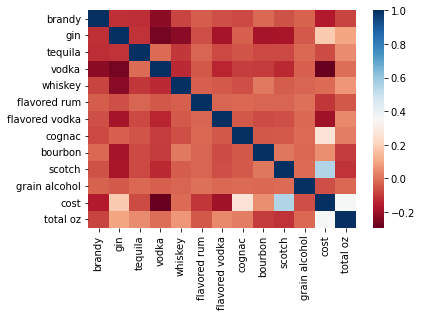

In [159]:
corr_heat = sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="RdBu")


In [160]:
df["cost"].corr(df["total oz"])
#justification for including total oz in regression

0.9717407567440367

In [161]:
def check_covar_costs():
    df_prices = pd.read_csv(INPUT_PATH, header=None)
    df_prices = df_prices.transpose()
    df_prices.columns = df_prices.loc[0]
    df_prices = df_prices.drop(0)
    df_prices = df_prices[["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol"]]
    return df_prices

In [162]:
check_covar_costs()

,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,brandy,scotch,grain alcohol
1,0.394,0.788,0.659687,0.391845,0.57,0.5,0.39668,2.263396,1.1,0.394,2.3,0.246667


In [163]:
def ols_regression():
    """Perform OLS regression of movie Revenue on IMBD Rating and genre dummies, and create png"""

    df = model_data()
    x_cols = ["brandy","gin","tequila","vodka","whiskey","flavored rum","flavored vodka","cognac","bourbon","brandy","scotch","grain alcohol", "total oz"]
 
    x = df[x_cols]
    y = df["cost"]
    display(df[x_cols])


    model = sm.OLS(y, sm.add_constant(x)).fit()
    model_summary = model.summary()

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.text(
        0.01, 0.05, str(model_summary), {"fontsize": 10}, fontproperties="monospace"
    )
    ax.axis("off")
    plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


,brandy,gin,tequila,vodka,whiskey,flavored rum,flavored vodka,cognac,bourbon,brandy,scotch,grain alcohol,total oz
strdrink,,,,,,,,,,,,,
1-900-FUK-MEUP,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.50
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.50
3 Wise Men,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.99
3-Mile Long Island Iced Tea,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.08
410 Gone,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
White Russian,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
Winter Paloma,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.19
Winter Rita,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.69


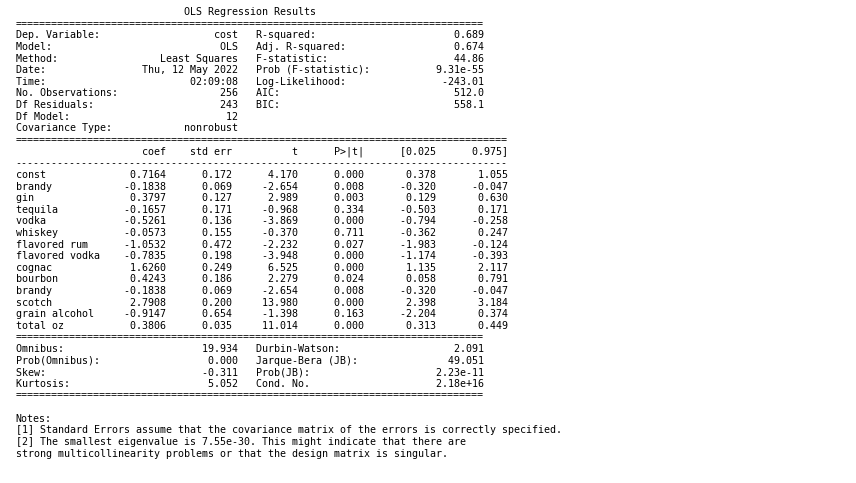

In [164]:
ols_regression()